<a href="https://colab.research.google.com/github/rmogi/HousePrice/blob/branch-mogi/mogi/HousePrices_Lasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


{'sample_submission.csv': b'Id,SalePrice\n1461,169277.0524984\n1462,187758.393988768\n1463,183583.683569555\n1464,179317.47751083\n1465,150730.079976501\n1466,177150.989247307\n1467,172070.659229164\n1468,175110.956519547\n1469,162011.698831665\n1470,160726.247831419\n1471,157933.279456005\n1472,145291.245020389\n1473,159672.017631819\n1474,164167.518301885\n1475,150891.638244053\n1476,179460.96518734\n1477,185034.62891405\n1478,182352.192644656\n1479,183053.458213802\n1480,187823.339254278\n1481,186544.114327568\n1482,158230.77520516\n1483,190552.829321091\n1484,147183.67487199\n1485,185855.300905493\n1486,174350.470676986\n1487,201740.620690863\n1488,162986.378895754\n1489,162330.199085679\n1490,165845.938616539\n1491,180929.622876974\n1492,163481.501519718\n1493,187798.076714233\n1494,198822.198942566\n1495,194868.409899858\n1496,152605.298564403\n1497,147797.702836811\n1498,150521.96899297\n1499,146991.630153739\n1500,150306.307814534\n1501,151164.372534604\n1502,151133.706960953\n

 **データタイプを調べる**

In [44]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso
)
%matplotlib inline

In [45]:
# データの読み込み
train = pd.read_csv('train.csv') #訓練データ
test = pd.read_csv('test.csv') #テストデータ
# 学習データとテストデータのマージ
train['WhatIsData'] = 'Train'
test['WhatIsData'] = 'Test'
test['SalePrice'] = 9999999999
alldata = pd.concat([train,test],axis=0).reset_index(drop=True)
print('The size of train is : ' + str(train.shape))
print('The size of test is : ' + str(test.shape))

The size of train is : (1460, 82)
The size of test is : (1459, 82)


In [46]:
# 学習データの欠損状況
train.isnull().sum()[train.isnull().sum()>0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [47]:
# テストデータの欠損状況
test.isnull().sum()[test.isnull().sum()>0].sort_values(ascending=False)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

In [48]:
# 欠損を含むカラムのデータ型を確認
na_col_list = alldata.isnull().sum()[alldata.isnull().sum()>0].index.tolist() # 欠損を含むカラムをリスト化
alldata[na_col_list].dtypes.sort_values() #データ型

TotalBsmtSF     float64
BsmtUnfSF       float64
BsmtFinSF2      float64
BsmtFinSF1      float64
GarageYrBlt     float64
BsmtFullBath    float64
GarageCars      float64
BsmtHalfBath    float64
GarageArea      float64
LotFrontage     float64
MasVnrArea      float64
GarageQual       object
GarageCond       object
GarageType       object
PoolQC           object
FireplaceQu      object
Fence            object
Functional       object
KitchenQual      object
GarageFinish     object
MSZoning         object
MiscFeature      object
BsmtFinType2     object
BsmtFinType1     object
BsmtExposure     object
BsmtCond         object
BsmtQual         object
MasVnrType       object
Exterior2nd      object
Exterior1st      object
Utilities        object
Alley            object
Electrical       object
SaleType         object
dtype: object

In [49]:
# データ型に応じて欠損値を補完する
# floatの場合は0
# objectの場合は'NA'
na_float_cols = alldata[na_col_list].dtypes[alldata[na_col_list].dtypes=='float64'].index.tolist() #float64
na_obj_cols = alldata[na_col_list].dtypes[alldata[na_col_list].dtypes=='object'].index.tolist() #object
# float64型で欠損している場合は0を代入
for na_float_col in na_float_cols:
    alldata.loc[alldata[na_float_col].isnull(),na_float_col] = 0.0
# object型で欠損している場合は'NA'を代入
for na_obj_col in na_obj_cols:
    alldata.loc[alldata[na_obj_col].isnull(),na_obj_col] = 'NA'

In [50]:
# マージデータの欠損状況
alldata.isnull().sum()[alldata.isnull().sum()>0].sort_values(ascending=False)

Series([], dtype: int64)

In [51]:
# カテゴリカル変数の特徴量をリスト化
cat_cols = alldata.dtypes[alldata.dtypes=='object'].index.tolist()
# 数値変数の特徴量をリスト化
num_cols = alldata.dtypes[alldata.dtypes!='object'].index.tolist()
# データ分割および提出時に必要なカラムをリスト化
other_cols = ['Id','WhatIsData']
# 余計な要素をリストから削除
cat_cols.remove('WhatIsData') #学習データ・テストデータ区別フラグ除去
num_cols.remove('Id') #Id削除
# カテゴリカル変数をダミー化
alldata_cat = pd.get_dummies(alldata[cat_cols])
# データ統合
all_data = pd.concat([alldata[other_cols],alldata[num_cols],alldata_cat],axis=1)

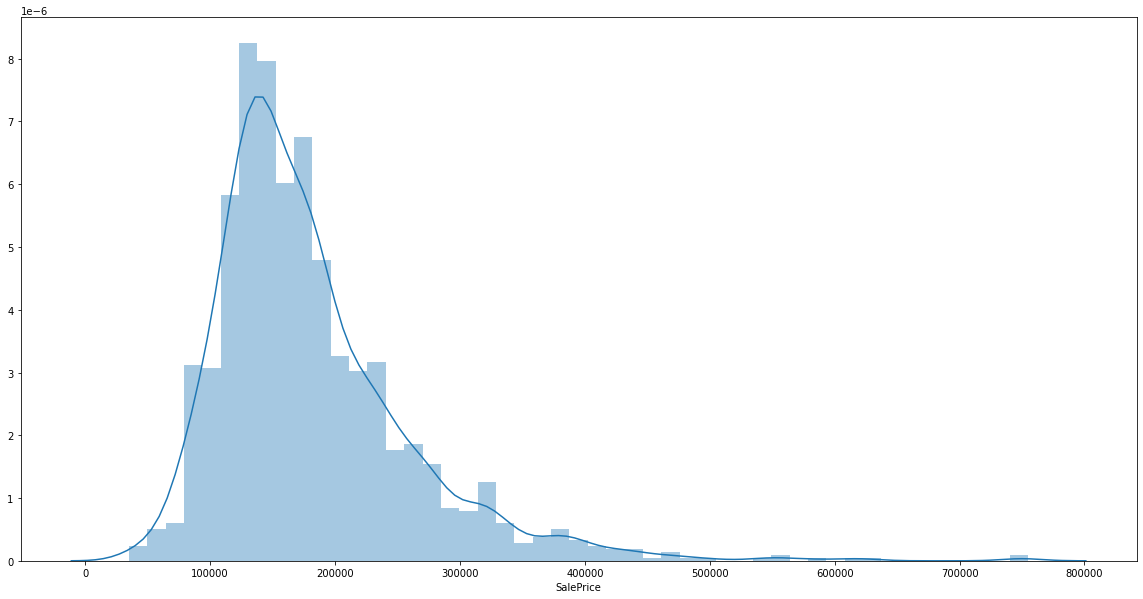

In [52]:
plt.figure(figsize=(20, 10), facecolor="w")
sns.distplot(train['SalePrice'])

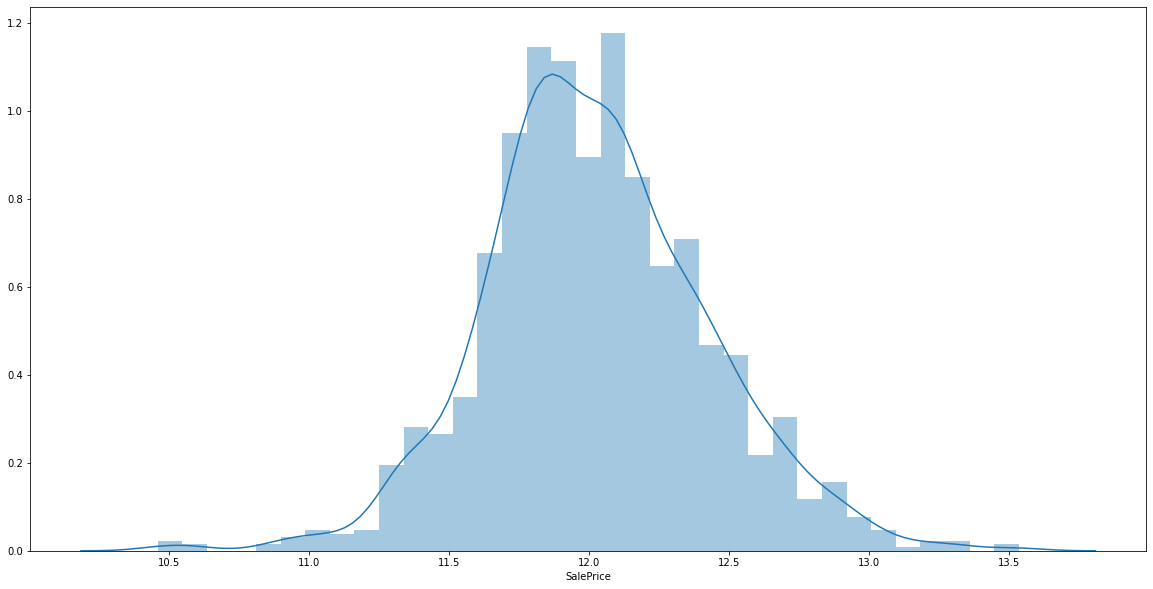

In [53]:
plt.figure(figsize=(20, 10), facecolor="w")
sns.distplot(np.log(train['SalePrice']))

In [54]:
# マージデータを学習データとテストデータに分割
train_ = all_data[all_data['WhatIsData']=='Train'].drop(['WhatIsData','Id'], axis=1).reset_index(drop=True)
test_ = all_data[all_data['WhatIsData']=='Test'].drop(['WhatIsData','SalePrice'], axis=1).reset_index(drop=True)
# 学習データ内の分割
train_x = train_.drop('SalePrice',axis=1)
train_y = np.log(train_['SalePrice'])
# テストデータ内の分割
test_id = test_['Id']
test_data = test_.drop('Id',axis=1)

In [55]:
scaler = StandardScaler()  #スケーリング
param_grid = [0.001, 0.01, 0.1, 1.0, 10.0,100.0,1000.0] #パラメータグリッド
cnt = 0
for alpha in param_grid:
    ls = Lasso(alpha=alpha) #Lasso回帰モデル
    pipeline = make_pipeline(scaler, ls) #パイプライン生成
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, random_state=0)
    pipeline.fit(X_train,y_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))
    test_rmse = np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test)))
    if cnt == 0:
        best_score = test_rmse
        best_estimator = pipeline
        best_param = alpha
    elif best_score > test_rmse:
        best_score = test_rmse
        best_estimator = pipeline
        best_param = alpha
    else:
        pass
    cnt = cnt + 1
    
print('alpha : ' + str(best_param))
print('test score is : ' +str(best_score))

alpha : 0.01
test score is : 0.18072873354655125


In [59]:
# 提出用データ生成
# test_id
ls = Lasso(alpha = 0.01)
pipeline = make_pipeline(scaler, ls)
pipeline.fit(train_x,train_y)
test_SalePrice = pd.DataFrame(np.exp(pipeline.predict(test_data)),columns=['SalePrice'])
test_Id = pd.DataFrame(test_id,columns=['Id'])
pd.concat([test_Id, test_SalePrice],axis=1).to_csv('test2.csv',index=False)